In [35]:
# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# data analysis libraries
import pandas as pd
import numpy as np

# general imports
from pathlib import Path

# auxiliary functions
import s3ts.analysis as aux

In [39]:
df = aux.load_data(Path("results_synced/atlas_ratio/"))
df["dataset"].value_counts()
#df = df[df["fold_number"] == 1]

GunPoint    66
Name: dataset, dtype: int64

/tmp/ipykernel_37416/1743217542.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (nsamp_pre, dfg) in enumerate(dfr.groupby(["nsamp_tra"])):


Text(0, 0.5, 'acc')

<Figure size 640x480 with 0 Axes>

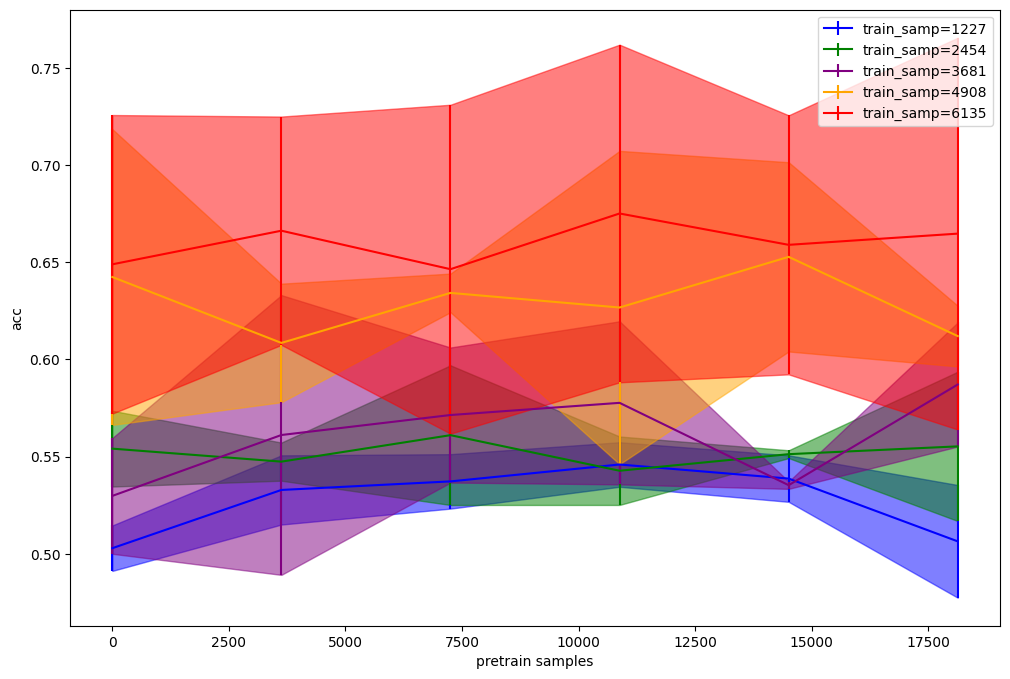

In [40]:
dfr = aux.EXP_ratio_preprocessing(df)
plt.figure()

metric = "acc"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])
for i, (nsamp_pre, dfg) in enumerate(dfr.groupby(["nsamp_tra"])):
    # ax.plot(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
     y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)

In [38]:
dfrb = aux.EXP_ratio_set_baselines(dfr)
dfrb

,arch,dataset,nsamp_pre,nsamp_tra,target_test_acc_mean,target_test_acc_std,target_test_auroc_mean,target_test_auroc_std,target_test_f1_mean,target_test_f1_std,target_val_acc_mean,target_val_acc_std,target_val_auroc_mean,target_val_auroc_std,target_val_f1_mean,target_val_f1_std
0,CNN_DFS,GunPoint,3627,1227,0.053968,NaN,0.055834,NaN,0.053968,NaN,0.241218,NaN,0.33451,NaN,0.241218,NaN
1,CNN_DFS,GunPoint,7254,1227,0.023559,NaN,0.036337,NaN,0.023559,NaN,0.088993,NaN,0.409292,NaN,0.088993,NaN
2,CNN_DFS,GunPoint,10881,1227,0.047619,NaN,0.046917,NaN,0.047619,NaN,0.088993,NaN,0.12457,NaN,0.088993,NaN
3,CNN_DFS,GunPoint,14508,1227,0.029407,NaN,0.060634,NaN,0.029407,NaN,0.112412,NaN,0.338134,NaN,0.112412,NaN
4,CNN_DFS,GunPoint,18135,1227,0.01604,NaN,0.061262,NaN,0.01604,NaN,0.103045,NaN,0.293137,NaN,0.103045,NaN
5,CNN_DFS,GunPoint,3627,2454,0.000167,NaN,-0.034839,NaN,0.000167,NaN,-0.009368,NaN,0.052555,NaN,-0.009368,NaN
6,CNN_DFS,GunPoint,7254,2454,-0.004678,NaN,-0.03013,NaN,-0.004678,NaN,-0.01171,NaN,0.059898,NaN,-0.01171,NaN
7,CNN_DFS,GunPoint,10881,2454,-0.010025,NaN,-0.029897,NaN,-0.010025,NaN,0.01171,NaN,0.033105,NaN,0.01171,NaN
8,CNN_DFS,GunPoint,14508,2454,0.009524,NaN,0.001991,NaN,0.009524,NaN,0.018735,NaN,0.025487,NaN,0.018735,NaN
9,CNN_DFS,GunPoint,18135,2454,-0.012197,NaN,-0.020509,NaN,-0.012197,NaN,-0.003513,NaN,-0.006389,NaN,-0.003513,NaN


Text(0, 0.5, 'f1')

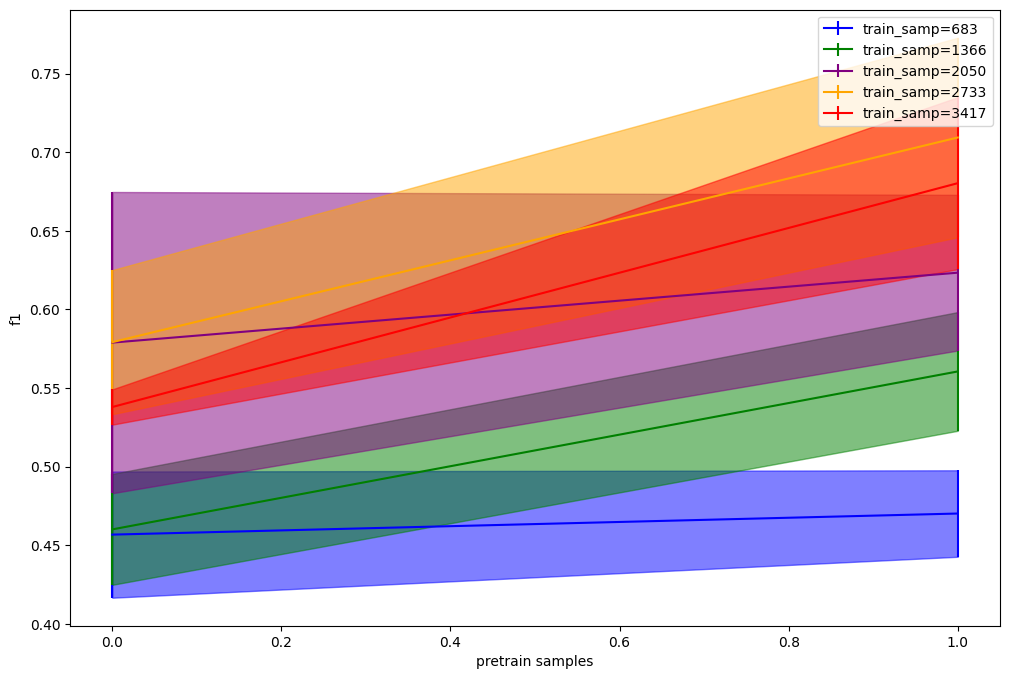

In [ ]:
dfs: pd.DataFrame = xd

metric = "f1"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])#plt.subplots(subplot_kw={"projection": "3d"})
for i, (nsamp, dfg) in enumerate(dfs.groupby(dfs["nsamp_tra"])):
    ax.errorbar(dfg["pretrained"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["pretrained"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
        y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)

In [3]:
dfs = df[df["dataset"] == ds].copy()
dfs = fix_close_vals(dfs,  "nsamp_pre")


cols = [c for c in dfs.columns if ("target_test" in c) or (("pretrain_val" in c) )]
xd0 = dfs[dfs["pretrained"] == False].groupby(["nsamp_tra"])[cols].mean()
xd1 = dfs.groupby(["nsamp_tra", "nsamp_pre"])[cols].max()
xd2 = dfs.groupby(["nsamp_tra", "nsamp_pre"])[cols].std()
print(dfs["nsamp_pre"].unique())

xd1.columns = [c + "_mean" for c in xd1.columns]
xd2.columns = [c + "_std" for c in xd2.columns]
xd = pd.concat([xd1, xd2], axis=1).reset_index()
xd.replace(np.NaN, 0, inplace=True)
xd

NameError: name 'df' is not defined

In [4]:
dfs: pd.DataFrame = xd

metric = "f1"

colors = ["blue", "green", "purple", "orange", "red"]
fig, ax = plt.subplots(figsize=[12,8])#plt.subplots(subplot_kw={"projection": "3d"})
for i, (nsamp, dfg) in enumerate(dfs.groupby(dfs["nsamp_tra"])):
    ax.errorbar(dfg["nsamp_pre"], dfg[f"target_test_{metric}_mean"], yerr=dfg[f"target_test_{metric}_std"], 
                label=f'train_samp={dfg["nsamp_tra"].unique()[0]}', c=colors[i])
    ax.fill_between(dfg["nsamp_pre"], y1=dfg[f"target_test_{metric}_mean"]+dfg[f"target_test_{metric}_std"], 
        y2=dfg[f"target_test_{metric}_mean"]-dfg[f"target_test_{metric}_std"], alpha = 0.5, color=colors[i])
plt.legend()
plt.xlabel("pretrain samples")
plt.ylabel(metric)

NameError: name 'xd' is not defined

In [5]:
xd = df[df["dataset"] == ds][["nsamp_tra", "nsamp_pre", "pretrained", "target_test_acc", 'target_best_model']]
xd[xd["nsamp_tra"] == 3417]

NameError: name 'df' is not defined

In [73]:
idx = 17
print(xd[xd["nsamp_tra"] == 3417].iloc[idx]["target_best_model"])
xd[xd["nsamp_tra"] == 3417].iloc[idx]

training/exp/EXP_ratio_f2.4_2023-02-26_22-51/logs/target/checkpoints/epoch=0-step=17.ckpt


nsamp_tra                                                         3417
nsamp_pre                                                         9995
pretrained                                                        True
target_test_acc                                               0.451613
target_best_model    training/exp/EXP_ratio_f2.4_2023-02-26_22-51/l...
Name: 239, dtype: object

<AxesSubplot: >

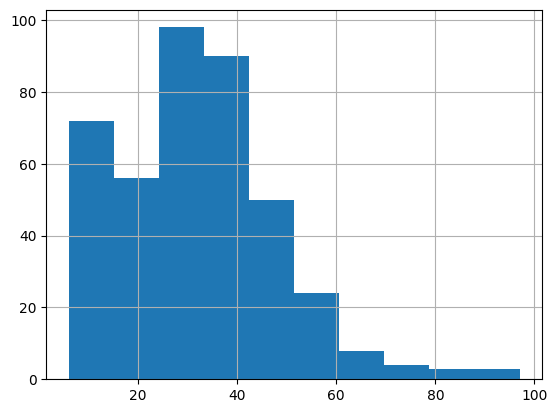

In [80]:
df[df["pretrained"]==True]["pretrain_nepochs"].hist()